In [1]:
%load_ext autoreload
%autoreload 2

import pydrake
import torch
import pyro
from pyro import poutine
import time
import matplotlib.pyplot as plt

import scene_generation.data.dataset_utils as dataset_utils
from scene_generation.models.planar_multi_object_multi_class_2_with_context import MultiObjectMultiClassModelWithContext

In [70]:
import numpy as np
DATA_DIR_TRAIN = "/home/gizatt/projects/scene_generation/data/planar_tabletop/planar_tabletop_lines_scenes_train/"
DATA_DIR_TEST = "/home/gizatt/projects/scene_generation/data/planar_tabletop/planar_tabletop_lines_scenes_test/"

scenes_dataset_yaml = dataset_utils.ScenesDataset(DATA_DIR_TRAIN)
params_by_object_class = {}
for env_i in range(len(scenes_dataset_yaml)):
    env = scenes_dataset_yaml[env_i]
    for obj_i in range(env["n_objects"]):
        obj_yaml = env["obj_%04d" % obj_i]
        class_name = obj_yaml["class"]
        if class_name not in params_by_object_class.keys():
            params_by_object_class[class_name] = []
        params_by_object_class[class_name].append(obj_yaml["pose"] + obj_yaml["params"])

for object_name in params_by_object_class.keys():
    print object_name, ": "
    params = np.stack(params_by_object_class[object_name])
    print params.shape
    print "means: ", np.mean(params, axis=0)
    print "vars: ", np.std(params, axis=0)

2d_box : 
(6613, 5)
means:  [0.01630386 0.009155   3.16016761 0.20026135 0.20045007]
vars:  [0.37565002 0.38130307 1.78801198 0.05833353 0.05739718]
2d_sphere : 
(6616, 4)
means:  [ 1.48485340e-02 -3.86011104e-04  3.12971213e+00  1.00026841e-01]
vars:  [0.37147863 0.37904951 1.83110556 0.02873518]


In [3]:
print len(scenes_dataset_yaml)

1635


In [71]:
scenes_dataset = dataset_utils.ScenesDatasetVectorized(
    DATA_DIR_TRAIN, max_num_objects=5,
    base_environment_type="planar_tabletop")
data = scenes_dataset.get_full_dataset()

scenes_dataset_test = dataset_utils.ScenesDatasetVectorized(
    DATA_DIR_TEST,max_num_objects=5,
    base_environment_type="planar_tabletop")
data_test = scenes_dataset_test.get_full_dataset()

print "Train batch size: ", data.batch_size
print "Test batch size: ", data_test.batch_size

Train # batches:  1635
Test # batches:  408


In [82]:
# Rig for SVI, running with AutoDelta, which converges fairly reliably but
# confuses the variances
from collections import defaultdict
from torch.distributions import constraints
from pyro.infer import Trace_ELBO, SVI
from pyro.contrib.autoguide import AutoDelta, AutoDiagonalNormal, AutoMultivariateNormal, AutoGuideList
import datetime
from tensorboardX import SummaryWriter
from scene_generation.models.planar_multi_object_multi_class_2_with_context import MultiObjectMultiClassModelWithContext

pyro.enable_validation(True)

log_dir = "/home/gizatt/projects/scene_generation/models/runs/pmomc2/" + datetime.datetime.now().strftime(
    "%Y-%m-%d-%H-%m-%s")
writer = SummaryWriter(log_dir)
def write_np_array(writer, name, x, i):
    for yi, y in enumerate(x):
        writer.add_scalar(name + "/%d" % yi, y, i)
        
print "All params: ", pyro.get_param_store().get_all_param_names()
#interesting_params = ["keep_going_weights",
#                      "new_class_weights"]

model = MultiObjectMultiClassModelWithContext(scenes_dataset, use_projection=False)
pyro.clear_param_store()
pyro.get_param_store().save("planar_multi_object_multi_class_2_with_context_lines_untrained.pyro")
#guide = AutoDelta(poutine.block(model.model, hide=["obs"]))

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.9, 0.99]})
elbo = Trace_ELBO(max_plate_nesting=1)
svi = SVI(model.model, model.guide, optim, loss=elbo)
losses = []
losses_test = []
best_on_test_loss = 0
best_test_loss = np.infty
cycles_since_improvement = 0

snapshots = {}
for i in range(2001):
    start_time = time.time()
    loss = svi.step(data, subsample_size=100) / data.batch_size
    losses.append(loss)
    writer.add_scalar('loss', loss, i)

    loss_test = svi.evaluate_loss(data_test, subsample_size=50) / data_test.batch_size
    losses_test.append(loss_test)
    writer.add_scalar('loss_test', loss_test, i)

    if loss_test < best_test_loss:
        best_on_test_loss = pyro.get_param_store().get_state()
        best_test_loss = loss_test
        cycles_since_improvement = 0
    else:
        cycles_since_improvement += 1
        if cycles_since_improvement > 100:
            print("Terminating early due to rising test loss")
            break

    #for p in interesting_params:
    #    write_np_array(writer, p, snapshots[p][-1], i)
    end_time = time.time()
    if (i % 1 == 0):
        print("Loss: %f, Loss_test: %f, Best test loss: %f, Time per step: %f" % (
            loss, loss_test, best_test_loss, end_time - start_time))
print "Done"

All params:  ['class_vars_generator_module_0$$$0.bias', 'class_means_generator_module_1$$$4.weight', 'class_means_generator_module_0$$$0.weight', 'keep_going_controller_module$$$2.weight', 'class_means_generator_module_0$$$2.weight', 'class_vars_generator_module_1$$$0.weight', 'class_vars_generator_module_1$$$4.weight', 'class_controller_module$$$4.weight', 'class_guide_module_0$$$6.weight', 'class_controller_module$$$0.weight', 'class_vars_generator_module_0$$$0.weight', 'context_updater_module$$$weight_hh_l0', 'keep_going_controller_module$$$0.weight', 'keep_going_controller_module$$$2.bias', 'class_guide_module_1$$$2.bias', 'class_guide_module_1$$$6.weight', 'class_guide_module_0$$$2.weight', 'class_guide_module_1$$$4.weight', 'class_vars_generator_module_1$$$4.bias', 'context_updater_module$$$weight_ih_l0', 'class_encoder_module_1$$$0.bias', 'class_encoder_module_1$$$4.bias', 'class_vars_generator_module_0$$$2.weight', 'keep_going_controller_module$$$0.bias', 'class_vars_generator_

Loss: 4.511723, Loss_test: 4.367907, Best test loss: 4.367907, Time per step: 0.289533
Loss: 4.463967, Loss_test: 4.250685, Best test loss: 4.250685, Time per step: 0.274831
Loss: 4.349821, Loss_test: 4.166135, Best test loss: 4.166135, Time per step: 0.339952
Loss: 4.262732, Loss_test: 4.091605, Best test loss: 4.091605, Time per step: 0.335760
Loss: 4.202678, Loss_test: 3.998837, Best test loss: 3.998837, Time per step: 0.354815
Loss: 4.136757, Loss_test: 3.947757, Best test loss: 3.947757, Time per step: 0.213940
Loss: 4.092440, Loss_test: 3.918630, Best test loss: 3.918630, Time per step: 0.238226
Loss: 4.047189, Loss_test: 3.890910, Best test loss: 3.890910, Time per step: 0.234760
Loss: 4.014414, Loss_test: 3.838970, Best test loss: 3.838970, Time per step: 0.228137
Loss: 3.976724, Loss_test: 3.817328, Best test loss: 3.817328, Time per step: 0.377488
Loss: 3.955631, Loss_test: 3.828058, Best test loss: 3.817328, Time per step: 0.350038
Loss: 3.948969, Loss_test: 3.806667, Best t

Process PoolWorker-14774:
Process PoolWorker-14773:
Process PoolWorker-14775:
Process PoolWorker-14764:
Traceback (most recent call last):
Process PoolWorker-14762:
Process PoolWorker-14777:
Process PoolWorker-14771:
Process PoolWorker-14763:
Process PoolWorker-14750:
Process PoolWorker-14755:
Process PoolWorker-14765:
Process PoolWorker-14761:
Process PoolWorker-14757:
Process PoolWorker-14767:
Process PoolWorker-14772:
Process PoolWorker-14758:
Process PoolWorker-14746:
Process PoolWorker-14778:
Traceback (most recent call last):
Process PoolWorker-14753:
Process PoolWorker-14747:
Traceback (most recent call last):
Process PoolWorker-14776:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-14748:
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-14780:
Tracebac

Loss: 3.743958, Loss_test: 3.594966, Best test loss: 3.585797, Time per step: 0.242258


  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
    self.run()
    self.run()
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
    self.run()
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
    self._target(*self._args, **self._kwargs)
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
    self._target(*self._args, **self._kwargs)
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/process.py", line 114, in run

  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/queues.py", line 374, in get
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/queues.py", line 374, in get
    task = get()
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
    self._target(*self._args, **self._kwargs)
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    self._target(*self._args, **self._kwargs)
    racquire()
    self._target(*self._args, **self._kwargs)
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/queues.py", line 374, in get
   

KeyboardInterrupt: 

Process PoolWorker-14793:
Process PoolWorker-14791:
Process PoolWorker-14782:
Process PoolWorker-14790:
Process PoolWorker-14787:
Process PoolWorker-14792:
Process PoolWorker-14788:
Process PoolWorker-14783:
Process PoolWorker-14786:
Process PoolWorker-14784:
Traceback (most recent call last):
Process PoolWorker-14785:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
Process PoolWorker-14789:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/process.py", line 267, in _bootst

Text(0.5,1,'Loses: final [3.808057 train][3.655563 test]')

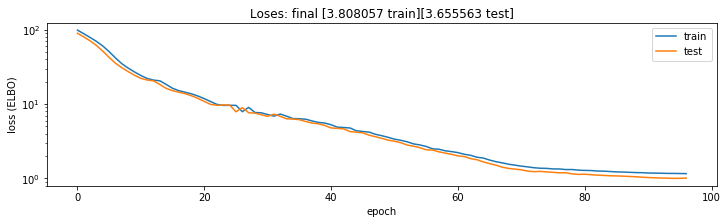

In [83]:
plt.figure().set_size_inches(12, 3)
offset = min(np.min(losses), np.min(losses_test))
plt.plot(losses - offset + 1., label="train")
plt.plot(losses_test - offset + 1., label="test")
plt.semilogy()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss (ELBO)")
plt.title("Loses: final [%f train][%f test]" % (np.mean(losses[-20:]), np.mean(losses_test[-20:])))

In [77]:
# Save model
#pyro.get_param_store().save("planar_multi_object_multi_class_2_simple_stacks_without_projection.pyro")
pyro.get_param_store().save("planar_multi_object_multi_class_2_simple_stacks_with_projection_constraints.pyro")

In [84]:
# Load model
pyro.clear_param_store()
model = MultiObjectMultiClassModelWithContext(scenes_dataset, use_projection=True)
#pyro.get_param_store().load("planar_multi_object_multi_class_2_simple_stacks_with_projection_no_constraints.pyro")
pyro.get_param_store().load("planar_multi_object_multi_class_2_simple_stacks_with_projection_constraints.pyro")

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.9, 0.99]})
elbo = Trace_ELBO(max_plate_nesting=1)
svi = SVI(model.model, model.guide, optim, loss=elbo)
print("Loaded model evaluated on test: ",
      svi.evaluate_loss(data_test, subsample_size=200) / data_test.batch_size)

('Loaded model evaluated on test: ', -27.864918428308822)


Process PoolWorker-14824:
Process PoolWorker-14831:
Process PoolWorker-14829:
Process PoolWorker-14827:
Process PoolWorker-14832:
Process PoolWorker-14840:
Process PoolWorker-14838:
Process PoolWorker-14830:
Process PoolWorker-14825:
Process PoolWorker-14834:
Process PoolWorker-14835:
Process PoolWorker-14837:
Process PoolWorker-14833:
Traceback (most recent call last):
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Process PoolWorker-14836:
Traceback (most recent call last):
Process PoolWorker-14823:
Process PoolWorker-14822:
Process PoolWorker-14826:
Process PoolWorker-14828:
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Process PoolWorker-14821:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
    self.run()
Traceback (most recent call last):
Process PoolWorker-14839:
Traceback (most recent call

  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/queues.py", line 374, in get
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
    task = get()
    task = get()
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    self._target(*self._args, **self._kwargs)
    task = get()
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
  File "/hom

In [94]:
# Convert that data back to a YAML environment, which is easier to
# handle.
for i in range(100):
    scene_with_most_objects = None
    for k in range(1):
        generated_data, generated_encodings, generated_contexts = model.model()
        scene_yaml = scenes_dataset.convert_vectorized_environment_to_yaml(
            generated_data)
        if scene_with_most_objects is None or scene_yaml[0]["n_objects"] > scene_with_most_objects["n_objects"]:
            scene_with_most_objects = scene_yaml[0]

    print scene_with_most_objects
    dataset_utils.DrawYamlEnvironment(scene_with_most_objects, "planar_tabletop")
    time.sleep(1.0)

{'obj_0002': {'color': [0.7448161728524862, 0.0, 1.0, 1.0], 'pose': [-0.4481217563152313, -0.4229315519332886, 3.856569290161133], 'params': [-0.06601868569850922], 'class': '2d_sphere', 'params_names': ['radius']}, 'obj_0003': {'color': [0.6384120332409893, 0.0, 1.0, 1.0], 'pose': [-0.12590321898460388, 0.040708720684051514, 5.4002509117126465], 'params': [0.17505353689193726, 0.2741020917892456], 'class': '2d_box', 'params_names': ['height', 'length']}, 'obj_0000': {'color': [0.6792407721045844, 0.0, 1.0, 1.0], 'pose': [-0.609595775604248, -0.31441453099250793, 1.2193553447723389], 'params': [0.37131667137145996], 'class': '2d_sphere', 'params_names': ['radius']}, 'obj_0001': {'color': [0.7526038346906895, 0.0, 1.0, 1.0], 'pose': [0.1831926703453064, -0.10200648009777069, 1.1111661195755005], 'params': [0.2572200298309326, 0.0675208568572998], 'class': '2d_box', 'params_names': ['height', 'length']}, 'obj_0004': {'color': [0.7266598308924326, 0.0, 1.0, 1.0], 'pose': [-0.0488274134695

KeyboardInterrupt: 

[1, 5, 5, 3, 5, 2, 2, 5, 5, 5, 4, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 1, 5, 5, 5, 4, 5, 5, 5, 5, 5, 3, 5, 5, 1, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 1, 1, 5, 5, 5, 5, 4, 2, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 4, 2, 3, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 2, 3, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 4, 3, 5, 5, 5, 5, 1, 5, 2, 5, 5, 5, 3, 5, 5, 5, 5, 5, 1, 2, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4]


(array([  0.,  10.,  11.,   8.,  10., 161.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 19 Patch objects>)

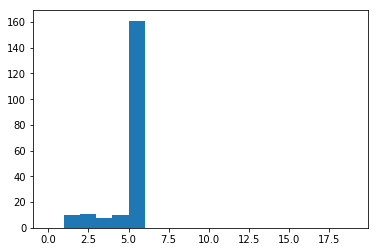

In [28]:
# Convert that data back to a YAML environment, which is easier to
# handle.
generated_n_objs = []
for i in range(200):
    generated_data, generated_encodings, generated_contexts = model.model()
    scene_yaml = scenes_dataset.convert_vectorized_environment_to_yaml(
            generated_data)
    generated_n_objs.append(scene_yaml[0]["n_objects"])
print generated_n_objs
plt.hist(generated_n_objs, bins=range(20))

In [29]:
import matplotlib.pyplot as plt
from scipy.stats import norm


class_weight_vals = pyro.param("new_class_weights").detach().numpy().copy()

# Use params_by_object_class from when we loaded dataset.
plt.figure().set_size_inches(6, 3)
plt.subplot(1, 2, 1)
plt.title("Learned distribution")
plt.bar([0, 1], class_weight_vals)
plt.xticks([0, 1], scenes_dataset.class_id_to_name)
plt.ylabel("Prob")
plt.subplot(1, 2, 2)
plt.title("Empirical distribution")
plt.bar([0, 1], [len(params_by_object_class[object_name]) for object_name in scenes_dataset.class_id_to_name])
plt.xticks([0, 1], scenes_dataset.class_id_to_name)
plt.ylabel("Count")
plt.tight_layout()


for object_name in params_by_object_class.keys():
    object_id = scenes_dataset.class_name_to_id[object_name]
    params_means = pyro.param("params_means_%d" % object_id).detach().numpy()
    params_vars = pyro.param("params_vars_%d" % object_id).detach().numpy()
    plt.figure().set_size_inches(18, 3)
    params = np.stack(params_by_object_class[object_name]).copy()
    #params[2, :] = (params[2, :] % np.pi)
    for k in range(params.shape[1]):
        if k >= 3:
            param_name = scenes_dataset.params_names_by_class[object_id][k - 3]
        else:
            param_name = ["x", "z", "theta"][k]
        print(object_name + "::" + param_name + ": %2.2f +/- %2.2f" % (params_means[k], params_vars[k]))
        plt.subplot(1, params.shape[1], k+1)
        plt.title(object_name + "::" + param_name)
        plt.ylabel("density")
        bins = None
        if k == 0:
            bins = np.linspace(-1., 1., 100)
        elif k == 1:
            bins = np.linspace(-1., 1., 100)
        elif k == 2:
            bins = np.linspace(0., 2*np.pi, 200)
        x_bins = plt.hist(params[:, k], label="Empirical", density=True, bins=bins)[1]
        x_range = np.linspace(x_bins[0], x_bins[-1], 100)
        plt.plot(x_range, norm.pdf(x_range, params_means[k], params_vars[k]), label="Learned")
        
    plt.tight_layout()
    

KeyError: 'new_class_weights'

In [ ]:
import scipy as sp
import scipy.stats
# Draw the keep_going CDF, which is the product of all previous keep_going vals.
keep_going_vals = pyro.param("keep_going_weights").detach().numpy().copy()
keep_going_pdf = np.zeros(keep_going_vals.shape[0])
for k in range(0, keep_going_pdf.shape[0]):
    keep_going_pdf[k] = np.prod(keep_going_vals[0:k])*(1. - keep_going_vals[k])
plt.figure().set_size_inches(12, 3)
plt.title("Blue: Empirical dist of # objects, Orange: Fit dist of # of objects (geometric)")
plt.xlabel("# of objects")
plt.ylabel("Density")
xbins = plt.hist([p["n_objects"] for p in scenes_dataset_yaml], bins=range(0, 21), density=True)[1]
plt.plot(xbins, sp.stats.geom.pmf(xbins, 1.-keep_going_vals[0]))
plt.xticks(range(20))
plt.tight_layout()

In [92]:
# Assume projection has been done for this trained model and saved to these files...

def generate_params_by_object_class(scenes_dataset_yaml):
    params_by_object_class = {}
    for env_i in range(len(scenes_dataset_yaml)):
        env = scenes_dataset_yaml[env_i]
        for obj_i in range(env["n_objects"]):
            obj_yaml = env["obj_%04d" % obj_i]
            class_name = obj_yaml["class"]
            if class_name not in params_by_object_class.keys():
                params_by_object_class[class_name] = []
            params_by_object_class[class_name].append(obj_yaml["pose"] + obj_yaml["params"])
    return params_by_object_class  

# Generate some examples
scene_yaml = []
for k in range(10):
    generated_data, generated_encodings, generated_contexts = model.model()
    scene_yaml += scenes_dataset.convert_vectorized_environment_to_yaml(generated_data)
params_by_object_class_nonpen = generate_params_by_object_class(scene_yaml)

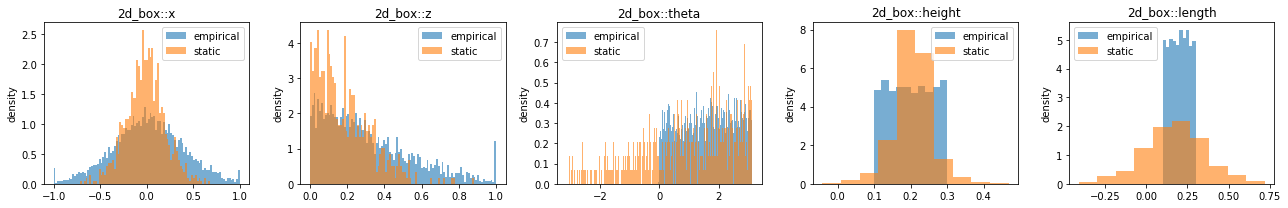

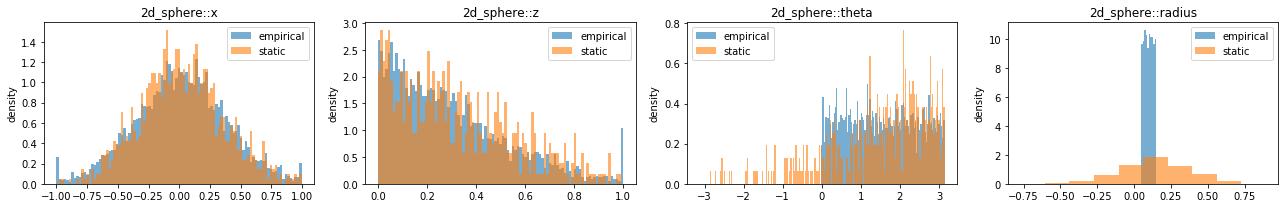

In [93]:
for object_name in params_by_object_class.keys():
    object_id = scenes_dataset.class_name_to_id[object_name]
    plt.figure().set_size_inches(18, 3)
    
    param_sets_base = [
        params_by_object_class[object_name],
        params_by_object_class_nonpen[object_name]
    ]
    #params_sets_names = ["empirical", "nonpenetrating", "static"]
    params_sets_names = ["empirical", "static"]
    
    param_sets = []
    for params in param_sets_base:
        params_stacked = np.stack(params).copy()
        #params_stacked[:, 2] = ((params_stacked[:, 2] + 2 * np.pi) % (2 * np.pi) - np.pi)
        param_sets.append(params_stacked)

    for k in range(param_sets[0].shape[1]):
        if k >= 3:
            param_name = scenes_dataset.params_names_by_class[object_id][k - 3]
        else:
            param_name = ["x", "z", "theta"][k]
        plt.subplot(1, param_sets[0].shape[1], k+1)
        plt.title(object_name + "::" + param_name)
        plt.ylabel("density")
        bins = None
        if k == 0:
            bins = np.linspace(-1., 1., 100)
        elif k == 1:
            bins = np.linspace(0., 1., 100)
        elif k == 2:
            bins = np.linspace(-np.pi, np.pi, 200)
        for i, params in enumerate(param_sets):
            x_bins = plt.hist(params[:, k], label=params_sets_names[i], density=True, bins=bins, alpha=0.6)[1]
        x_range = np.linspace(x_bins[0], x_bins[-1], 100)
        plt.legend()
        
    plt.tight_layout()